In [1]:
## try this with new data starting RCS02
import h5py
import numpy as np 
import matplotlib.pyplot as plt
from pathlib import Path
import scipy as sp
import sys
from datetime import date
import pandas as pd

In [6]:
sys.path.append("/home/jiahuang/test-code-hazel/gen-fxns/seeg-signal/Signal-proc/")
# filepath = sys.argv[1] 
ptID = 'RCS02'
filepath = f"/userdata/rvatsyayan/AnushaData/HDF5 Pain Data/{ptID}/101.h5"
from preproc_fxns import demean_signal

In [ ]:
# electrode_df = pd.DataFrame(f1['electrode_properties']).stack().str.decode('utf-8').unstack()
# electrode_df_t = electrode_df.T
# electrode_df_t['Lead Number'] = electrode_df_t[1]+electrode_df_t[2]
# electrode_df_t.iloc[4]


0                                 7
1                              RSGC
2                                 7
3                               OOB
4                               OOB
5                               CSF
6                  R CorpusCallosum
7              R CorpusCallosumGenu
8                             White
9                                 0
10                               12
11                               42
12                                6
13                               18
14                               31
15                                1
16                            Tract
17                            Right
18                               CC
19                                0
Lead Number                   RSGC7
Name: 4, dtype: object

shape of intracranial EEG


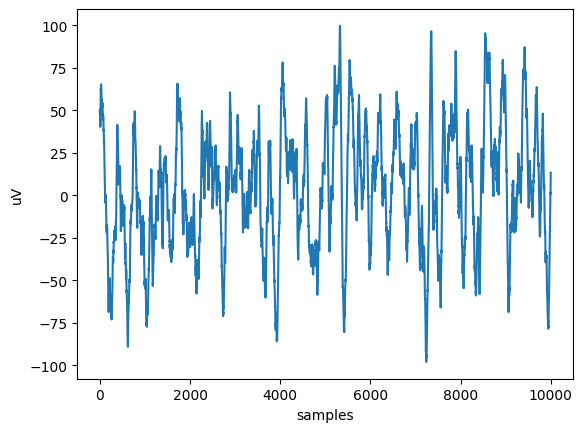

In [7]:
f1 = h5py.File(filepath)
srate = np.array(f1['frequency'])[0]
num_ch = f1['electrode_properties'].shape[1]
ch_label_unformat = f1['electrode_properties']
# Convert bytes literals to strings
decoder = np.vectorize(lambda x: x.decode('utf-8'))
#join channel label and number
join_string = lambda x: ''.join(x)

# Create an empty list to store the decoded strings
decoded_labels = []
new_label = []
ch_label = []
# Loop through each byte string in ch_label_unformat
for i in ch_label_unformat:
    # Decode each byte string using utf-8 and append to the list
    decoded_string = decoder(ch_label_unformat)

for x in range(0, num_ch):
    #print("We're on time %d" % (x))
    new_label = join_string(decoded_string[:,x])
    ch_label.append(new_label)

EEG = 'ieeg_data'
shape = f1[EEG].shape
intracranialEEG_data = np.zeros(shape, dtype=np.float32)
f1[EEG].read_direct(intracranialEEG_data)
# samples x channels array 

# test plot 
np.shape(intracranialEEG_data)
def plot_data(data, t_max=10000, plot_max=1):
    for i in range(plot_max):
        plt.plot(data[:t_max, i])
        ax1 = plt.xlabel('samples', fontsize=10)
        ax2 = plt.ylabel('uV', fontsize=10)

print('shape of intracranial EEG')
# np.shape(f1['intracranialEEG'])
plot_data(intracranialEEG_data)


In [8]:
# len(ch_label)

In [9]:
from preproc_fxns import demean_signal, downsample_signal, butterworth_notch_filter

ch_baseline_demean = demean_signal(intracranialEEG_data)
srate_new = 1000 # new sampling rate

print(ch_baseline_demean.dtype)
ds = downsample_signal(ch_baseline_demean, srate, srate_new)
print('downsampled data')

notch_freqs = [60, 120, 180, 240]
order = 4       # Example value, replace with the actual value
num_ch = ds.shape[1]
filt_data = butterworth_notch_filter(ds,order, notch_freqs[0], srate_new, num_ch)
filt_data = butterworth_notch_filter(filt_data,order, notch_freqs[1], srate_new, num_ch)
filt_data = butterworth_notch_filter(filt_data,order, notch_freqs[2], srate_new, num_ch)
filt_data = butterworth_notch_filter(filt_data,order, notch_freqs[3], srate_new, num_ch)
# The filtered data is now stored in filt_data

float32
downsampled data


In [ ]:
# ch_label[0]

'1RSGC1RightRectalGyrus / straight gyrus/ medial orbitalR OFCGreyR OFCR postOFCWhite11229-101817-17CorticalRightOFC0'

In [11]:
import re
import numpy as np

electrode_dict = {}

# Group channels by base electrode name (everything before the digits)
for idx, label in enumerate(ch_label):
    match = re.search(r"([A-Za-z]+)(\d+)", label)
    if match:
        base = match.group(1)
        if base not in electrode_dict:
            electrode_dict[base] = []
        electrode_dict[base].append(idx)

# Sort indices within each electrode by numeric order
for base in electrode_dict:
    electrode_dict[base] = sorted(electrode_dict[base], key=lambda i: int(re.findall(r'\d+', ch_label[i])[0]))

# Now build your list of index arrays (one per probe)
indices_for_probes = list(electrode_dict.values())

# Confirm
for k,v in electrode_dict.items():
    print(f"{k}: {v}")

# for base, idxs in electrode_dict.items():
#     print(f"{base}: {[ch_label[i] for i in idxs]}")

# Re-reference
from preproc_fxns import rereference
reref_data = rereference(filt_data, len(indices_for_probes), indices_for_probes, ch_label, 'bipolar')
print("✅ rereference complete")

# bipolar_zero = [15,31,47,63,79,95,111,127,143,159,199,207,215,223]

# reref_clean = np.delete(reref_data, bipolar_zero, 1)



RSGC: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]
LSGC: [14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]
RACC: [30, 31, 32, 33, 34, 35, 36, 37, 38, 39]
LACC: [40, 41, 42, 43, 44, 45, 46, 47, 48, 49]
RVPN: [50, 51, 52, 53, 54, 55, 56, 57, 58, 59]
RM: [60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75]
LAI: [76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91]
LPI: [92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107]
LVC: [108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123]
✅ rereference complete


In [12]:
# convolve 
num_frequencies = 48 #updated to capture more frequencies 11/06/2025
min_freq = 1  # Hz
max_freq = 150  # Hz
num_ch = 16 #### TEMPORARY FOR TESTING 

freqs = np.logspace(np.log10(min_freq), np.log10(max_freq), num_frequencies)
wave_num = np.tile(7,(len(freqs),1))

decomp_signal_array = np.zeros(shape=(len(freqs),len(filt_data),num_ch), dtype=np.float32)
#decomp_signal_phase = np.zeros(shape=(len(freqs),len(reref_data),num_ch))

from wavelet_decomp import decomp_wavelet

max_win_factor = 1.5 # prev 2.5 but looked like it was too large of window 
for ichan in range(num_ch):
    tmp_amplitude, tmp_phase = decomp_wavelet(reref_data[:,ichan].T,freqs,srate_new,wave_num, max_win_factor)
    decomp_signal_array[:,:,ichan] = tmp_amplitude
    #decomp_signal_phase[:,:,ichan] = tmp_phase

print('wavelet decomposition completed')

power_signal_array = decomp_signal_array ** 2

print('wavelet decomposition completed')

from scipy.signal import decimate
# decimate with anti-aliasing
decimation_factor = 7

# Fix: Calculate the actual decimated size first
test_decimated = decimate(power_signal_array[0, :, 0], decimation_factor, n=4, ftype='iir', zero_phase=True)
n_time_decimated = len(test_decimated)  # Get the actual size

# Now create array with correct size
resampled_psd = np.zeros((num_frequencies, n_time_decimated, num_ch), dtype=np.float32)

# Now this should work without error
for i in range(num_frequencies):
    for j in range(num_ch):
        resampled_psd[i, :, j] = decimate(power_signal_array[i, :, j], 
                                         decimation_factor, 
                                         n=4,
                                         ftype='iir', 
                                         zero_phase=True)

wavelet decomposition completed
wavelet decomposition completed


In [82]:
from plot_preproc_channel import plot_all_channels
save_dir = f"/userdata/jiahuang/pain-data/Stage1-test/{ptID}/biomarker/preproc_data/preproc_figs"

# Make sure directory exists
import os
os.makedirs(save_dir, exist_ok=True)

# Use keyword argument for save_dir
plot_all_channels(filt_data, reref_data, resampled_psd, 
                 freqs, ch_label, save_dir, channels_to_plot=range(2))

/home/jiahuang/test-code-hazel/gen-fxns/seeg-signal/Signal-proc/plot_preproc_channel.py:81: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


In [14]:
import re
savepath = f"/userdata/jiahuang/pain-data/Stage1-test/{ptID}/biomarker/preproc_data/"

h5_filename = re.findall(r"(\d+).h5", filepath)[0] + "_wavelet.h5"
full_filename = savepath + h5_filename
print(full_filename)

/userdata/jiahuang/pain-data/Stage1-test/RCS02/biomarker/preproc_data/101_wavelet.h5


In [ ]:
# save psd, mean, re-referenced data
from scipy.stats import zscore
psd_z = zscore(power_signal_array, axis=1)
mean_psd = np.nanmean(resampled_psd,axis=1)
median_psd = np.nanmedian(resampled_psd,axis =1)

savepath = f"/userdata/jiahuang/pain-data/Stage1-test/{ptID}/biomarker/preproc_data/"

h5_filename = re.findall(r"(\d+).h5", filepath)[0] + "_wavelet.h5"
full_filename = savepath + h5_filename
print(full_filename)
## save in h5 file 
import os
version = '1.0'
hf = h5py.File(full_filename, 'w')
hf.create_dataset('decomp_signal', data=resampled_psd)

hf.attrs['description'] = 'data preprocessed: demean, downsample, notch filter, re-reference, PSD computed'
hf.attrs['filename'] = filepath
hf.attrs['srate_new'] = srate_new
hf.attrs['notch_freqs'] = notch_freqs
hf.attrs['freqs'] = freqs
hf.attrs['version'] = version
hf.attrs['ch_labels'] = ch_label
hf.attrs['PatientID'] = ptID
hf.attrs['num_ch'] = num_ch
hf.attrs['last_sample'] = reref_data.shape[0]
# hf.attrs['stats_artifact'] = stats_artifact

# get date
today_date = date.today()
date_string = today_date.strftime("%Y-%m-%d")
hf.attrs['date preprocessed'] = date_string
hf.close()
print('wavelet data saved')

/userdata/jiahuang/pain-data/Stage1-test/RCS02/biomarker/preproc_data/1_wavelet.h5
wavelet data saved


In [ ]:

## save in h5 file 
directory, filename = os.path.split(filepath)
filename_no_ext, ext = os.path.splitext(filename)
meanpsd_filename = re.findall(r"(\d+).h5", filepath)[0]+ '_meanpsd' + ".h5"

hf1 = h5py.File(savepath+meanpsd_filename, 'w')
hf1.create_dataset('mean_psd', data=mean_psd)

hf1.attrs['description'] = 'data preprocessed: demean, downsample, notch filter, re-reference, PSD computed'
hf1.attrs['filename'] = filepath
hf1.attrs['srate_new'] = srate_new
hf1.attrs['notch_freqs'] = notch_freqs
hf1.attrs['freqs'] = freqs
hf1.attrs['version'] = version
hf1.attrs['ch_labels'] = ch_label
hf1.attrs['PatientID'] = ptID
hf1.attrs['num_ch'] = num_ch
hf1.attrs['last_sample'] = reref_data.shape[0]
# hf.attrs['stats_artifact'] = stats_artifact
# get date
today_date = date.today()
date_string = today_date.strftime("%Y-%m-%d")
hf1.attrs['date preprocessed'] = date_string

hf1.close()
print('mean psd data saved')

mean psd data saved


In [ ]:

## save re-referenced data in h5 file 
reref_filename = re.findall(r"(\d+).h5", filepath)[0] + '_reref' + ".h5"

hf1 = h5py.File(savepath+reref_filename, 'w')
hf1.create_dataset('re-referenced', data=reref_data)

hf1.attrs['description'] = 'data preprocessed: demean, downsample, notch filter, re-reference, PSD computed'
hf1.attrs['filename'] = filepath
hf1.attrs['srate_new'] = srate_new
hf1.attrs['notch_freqs'] = notch_freqs
hf1.attrs['freqs'] = freqs
hf1.attrs['version'] = version
hf1.attrs['ch_labels'] = ch_label
hf1.attrs['PatientID'] = ptID
hf1.attrs['num_ch'] = num_ch
hf1.attrs['last_sample'] = reref_data.shape[0]
# hf.attrs['stats_artifact'] = stats_artifact
# get date
today_date = date.today()
date_string = today_date.strftime("%Y-%m-%d")
hf1.attrs['date preprocessed'] = date_string

hf1.close()
print('reref data saved')

reref data saved


In [76]:
import pickle 
# pkl_fname = f"/userdata/aallawala/presidio_data/Stage1/{ptID}/biomarker/preproc_data/"
pkl_fname = 'tmp' + '_stats_artifact' + '.pkl'

with open(pkl_fname, 'wb') as handle:
    pickle.dump(stats_artifact, handle, protocol=pickle.HIGHEST_PROTOCOL)